# Hand-in 3, Part 1: Data handling and exploration

In this first notebook you will show us how you handle data being separated over several files, as well as exploring the quality and properties of your data.

In [66]:
from IPython.core.display import HTML
css_file = './31380.css'
HTML(open(css_file, "r").read())

#### Section 1: bash scripting

You have downloaded a zip file containing 5 CSV files, each containing part of the data you need. First, use your bash tools to look at the headers and size of the file. What do the different files contain?

Write a bash script that concatenates the 4 data files (except the flow_criticality_data.csv file). Exlain in the markdown cell below, what each part of your script does.

In [ ]:
#Following is the bash script called 'concatenate_csv.sh'
#All lines have been commented because they shoudn't be run in a notebook. 
#!/bin/bash

#cat ./energy_demand_data.csv > temp1
#cut -f 1 -d ',' --complement ./exchange_data.csv > temp2
#cut -f 1 -d ',' --complement ./generator_production_data.csv > temp3
#cut -f 1 -d ',' --complement ./renewable_production_data.csv > temp4

#paste -d ',' temp1 temp2 temp3 temp4 > concatenated.csv && rm -f ./temp*

**Q#1** *Explain your script here (by double clicking on this text).* 

This script concatenates four specific .csv files, where the headers are appended beside each other. The four files have a 'time' column in common, so only three of the files have this column removed. The script saves all four files in temporary files, where one has the timestamp column. The files are concatenated into a file called 'concatenated.csv'.

## Section 2: Visualizing the data
Here you will plot the resulting data file from the previous section, and plot it in order to identify missing data and see if you can already draw some conclusions on the data.

* *Hint: remember the hint given in Exc.13.3, on how to find out if your data contains NaN values*

In [1]:
# You will probably be needing the following libraries:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook
import numpy as np

In [67]:
# Import your data here
df = pd.Series()
df['raw'] = pd.read_csv('concatenated.csv')
df['raw'] = df['raw'].set_index('time')
df['raw'].shape

(8784, 136)

<IPython.core.display.Javascript object>


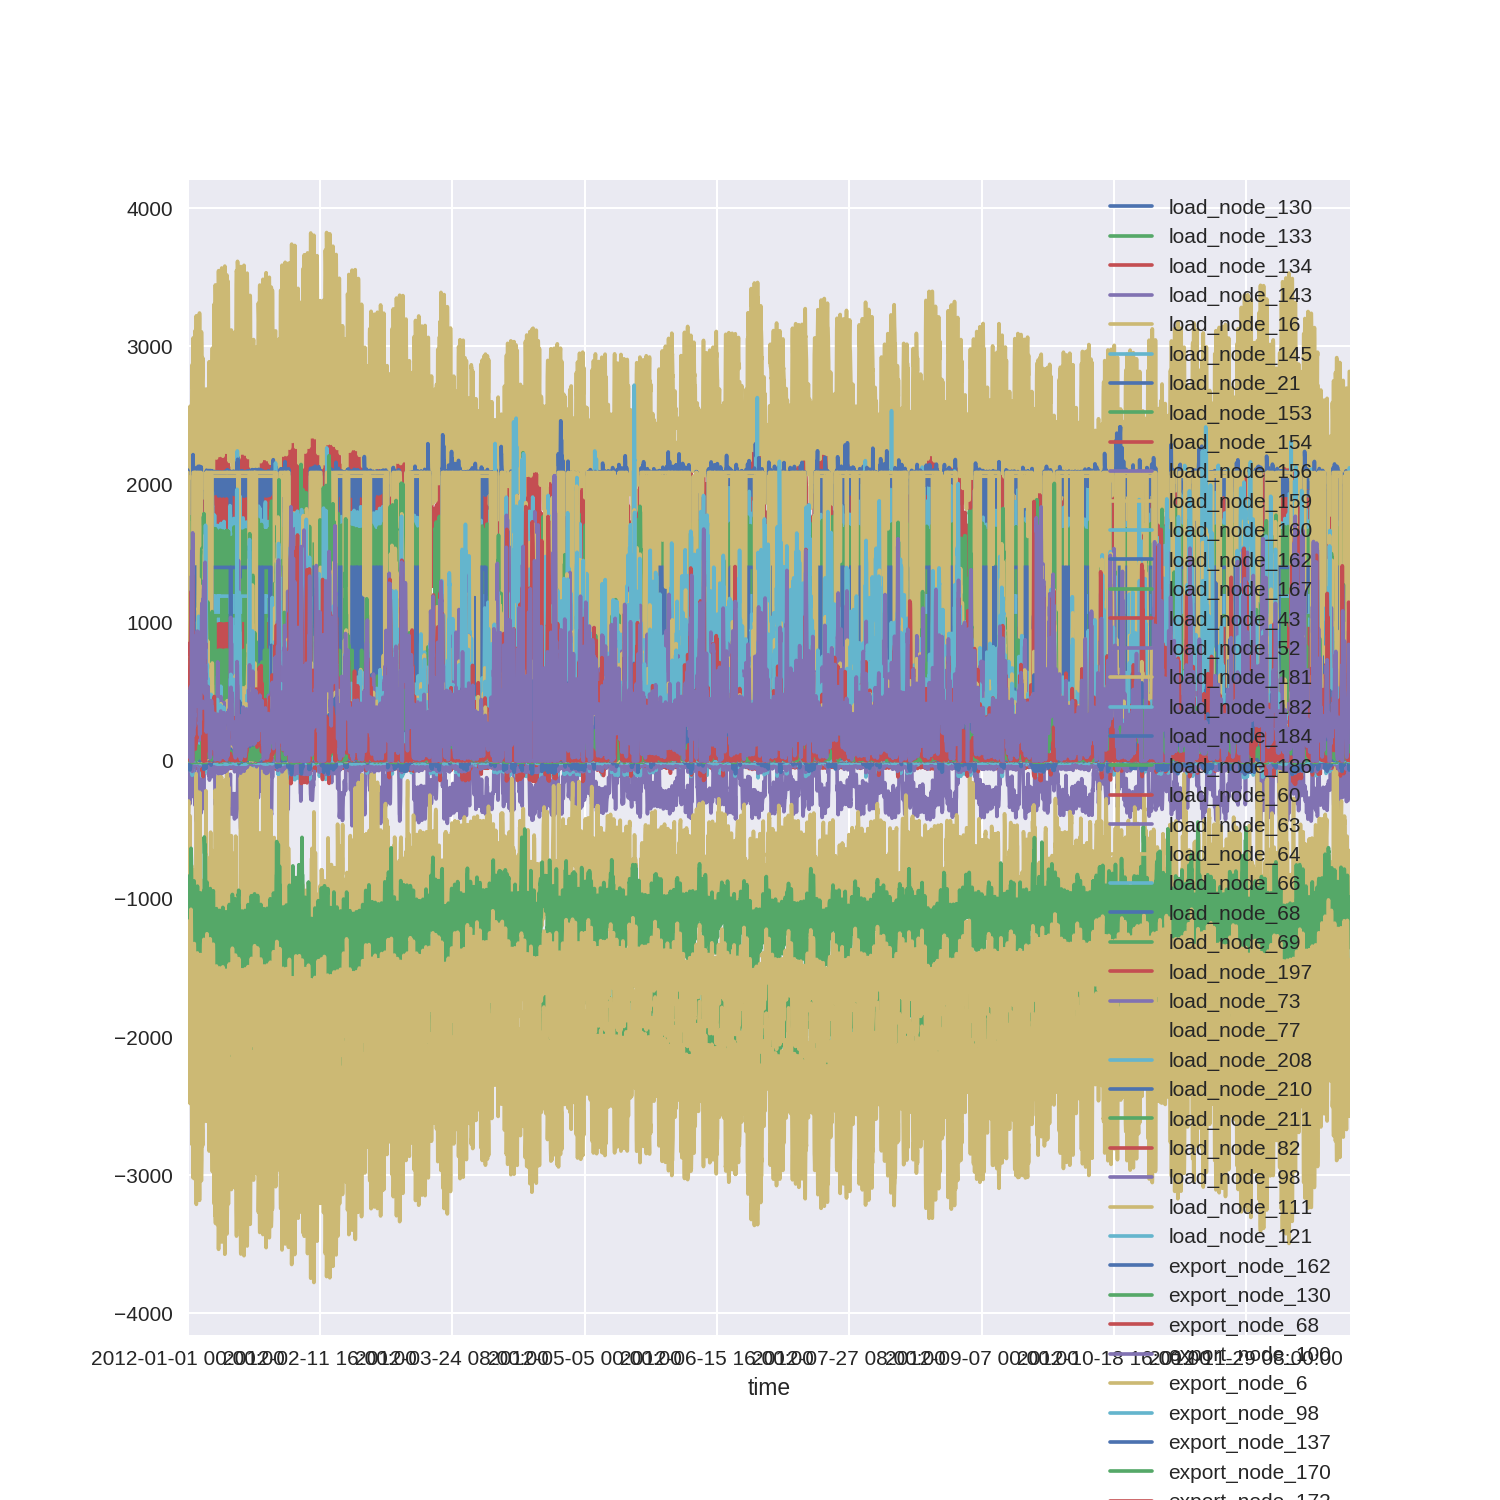

In [68]:
# First do some time series plots on the data, would it be practical to plot all possible scatter plots (scatter matrix)?
df['raw'].plot(figsize=(10,10));

Since the data contains so many attributes, it doesn't make sence to make a scatter matrix. On figure 1 a timeseries plot has been plotted with all attributes, this looks very messy but it's seen that there isn't any particular area where the data is missing.

Further investigation will be conducted using missing value matrices.

<IPython.core.display.Javascript object>


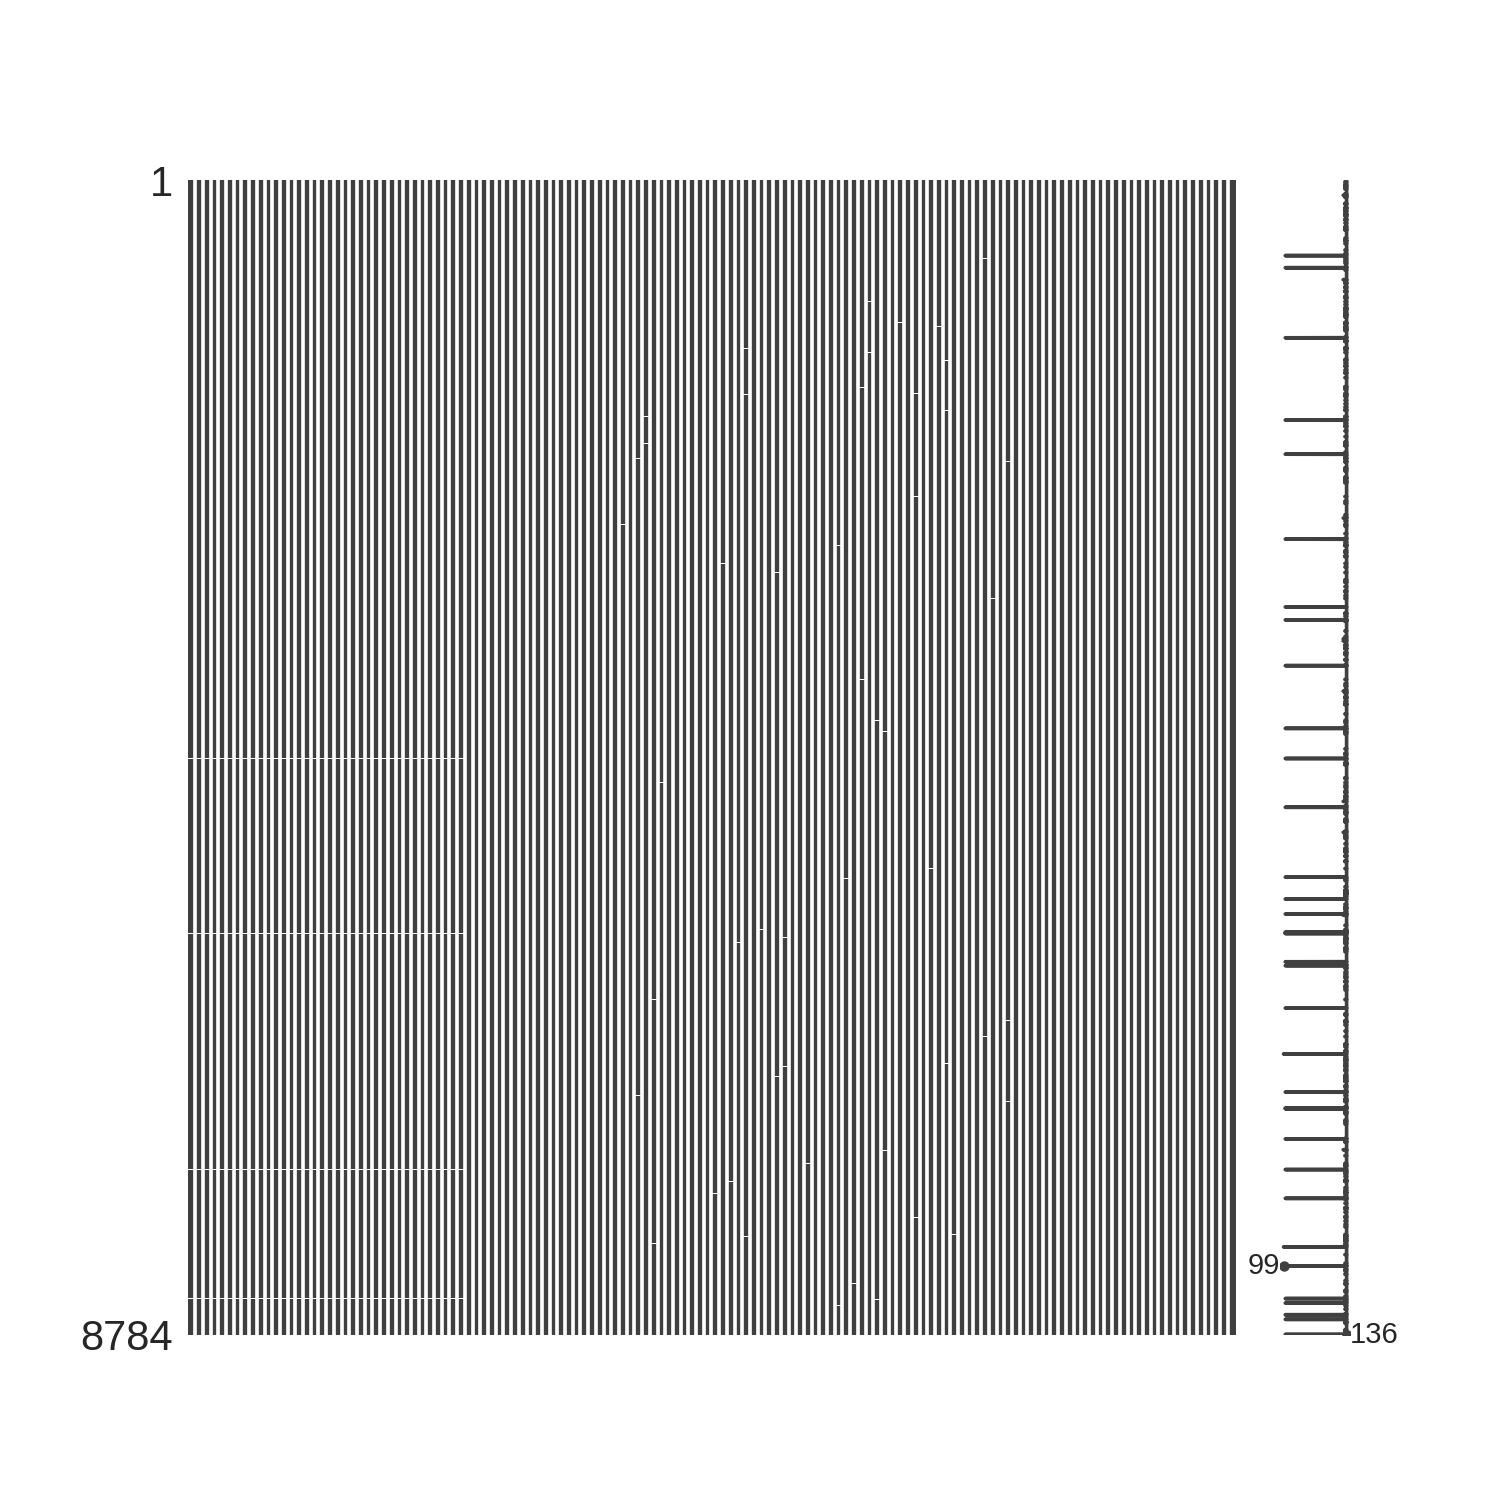

1711 lines contains nans


In [79]:
import missingno as msno
msno.matrix(df['raw'],figsize=(10,10))
print(df['raw'].isnull().values.ravel().sum(), 'lines contains nans')

**Q#2** For this data, what is the reasonable approach to dealing with the NaN values? Why?

From the missing value matrix it is clear that the missing values seem to be randomly distributed. Based on the timeseries plot and the missing value matrix inspection, interpolation doesn't seem like a feasible solution. 

The rows containing N/A will now be removed from the dataframe.

<IPython.core.display.Javascript object>


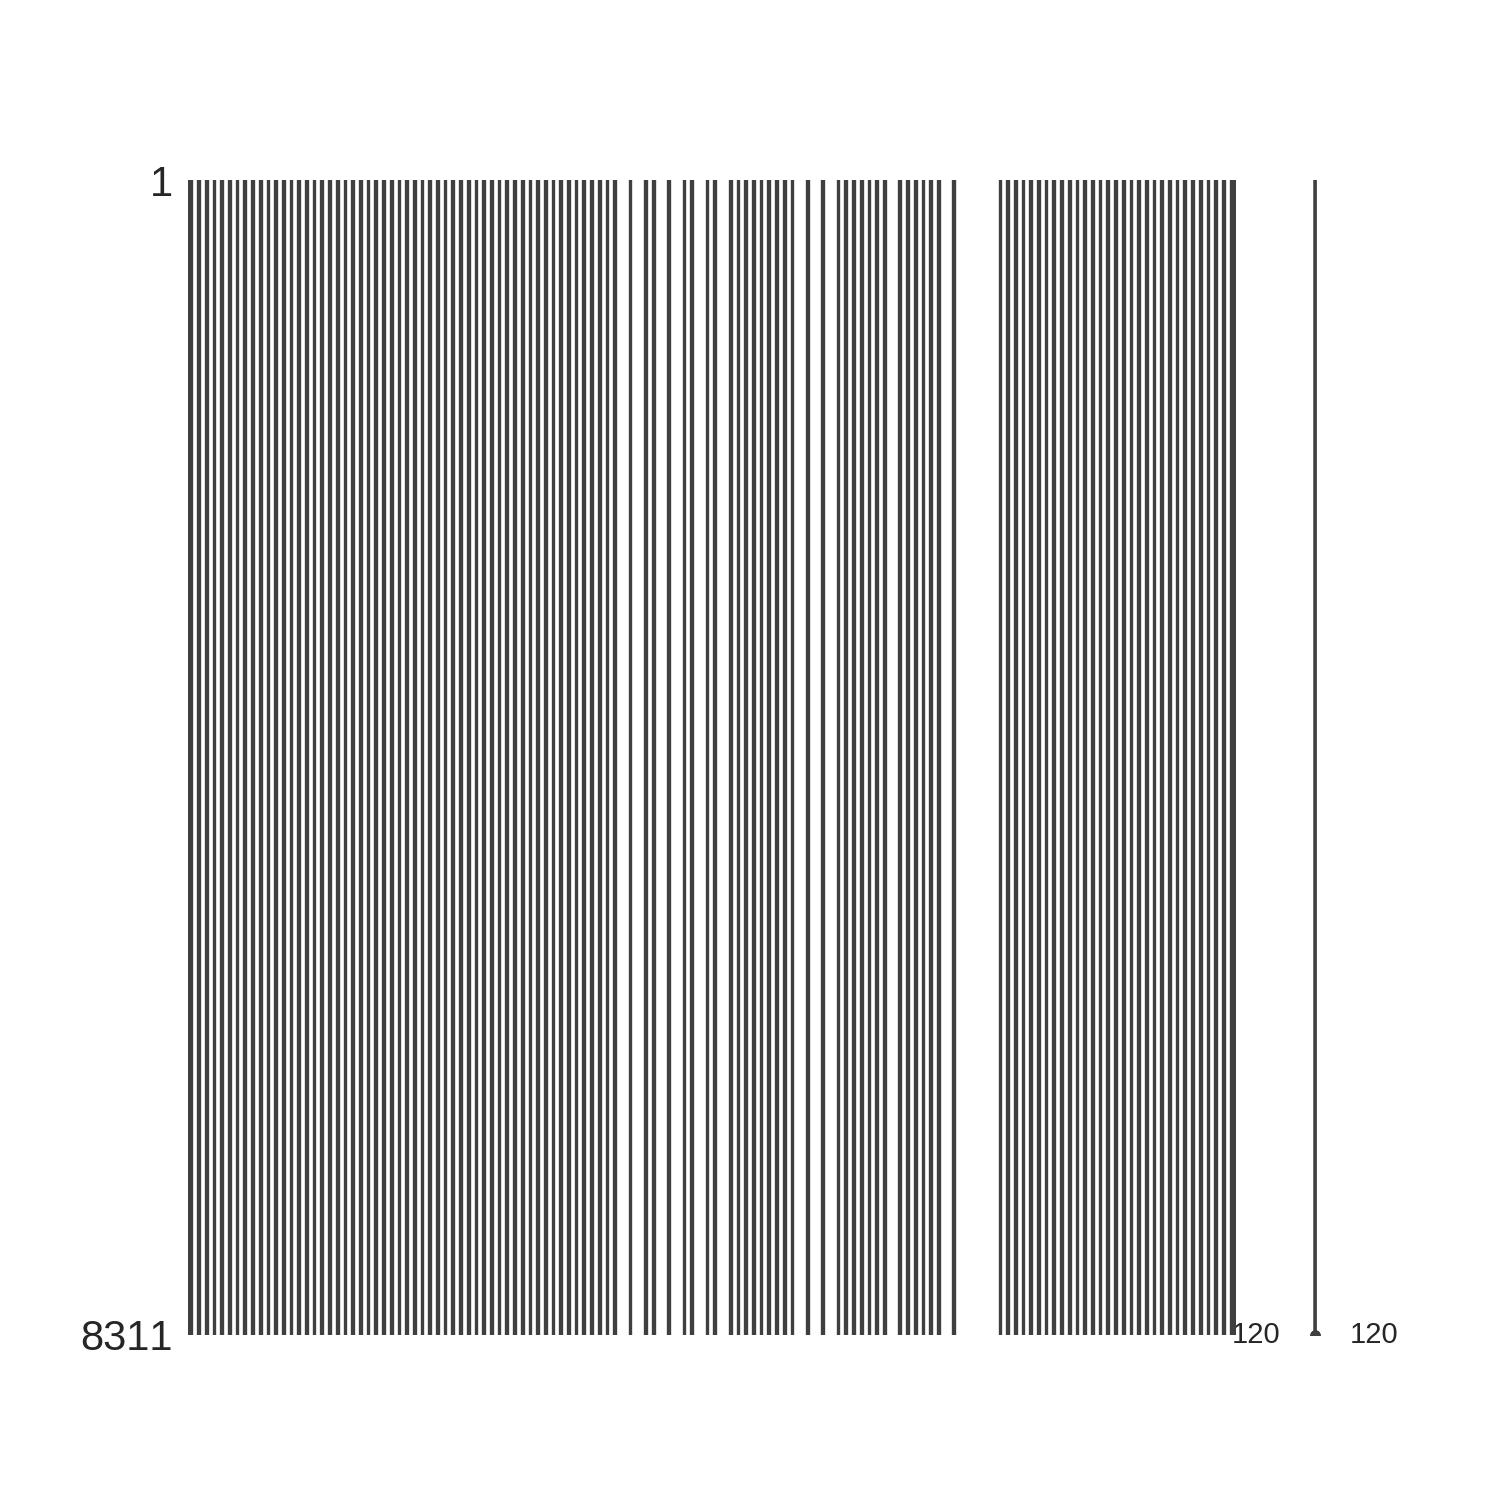

Number of columns with 0 variance: 16


In [82]:
# Get rid of your NaNs here
df['no_nan'] = df['raw'].dropna()

from scipy import stats

# standardize for PCA
df['std'] = ((df['no_nan']-df['no_nan'].mean())/df['no_nan'].std())
msno.matrix(df['std'],figsize=(10,10))
print("Number of columns with 0 variance:" ,df['no_nan'].std().value_counts()[0])

After the data has been standardized, 16 columns now appears as N/A. 

When standardization produces N/A it means that the standard deviation of that column is 0.

Since a standard deviation of 0, translates to all values being equal, and therefore the columns doesn't contribute with any information. 

The columns will now be removed from the standardized data.

In [83]:
df['std']= df['std'].dropna(axis=1)

### Feature reduction
Since you must reduce the amount of sensors, you need to find out which ones you can get rid of. 

**Q#3** Why would PCA be useful for this?

A PCA tries to capture the variance of a higher dimension, with fewer dimensions. This is essentially what will be done on the data.

By projecting the features onto a PCA and clustering the results, we can choose one attribute which represent each cluster the best.

In [88]:
from sklearn.decomposition import PCA

# Do your PCA here.
Ncomponents = 26
pca = PCA(n_components=Ncomponents)
pca.fit(df['std']);

#The goal here is to find the least number of components to explain 90 % of the cumulative variance.
cum_exp_var = pca.explained_variance_ratio_.sum()*100
print(f"Cumulative explained variance: {cum_exp_var}")

Cumulative explained variance: 90.34747623566692


### Scree plot
**Q#4** How many principal components do you need to explain 90 % of the variance? 

With 26 principal components, more than 90% of the variance in the data is explained.

<IPython.core.display.Javascript object>


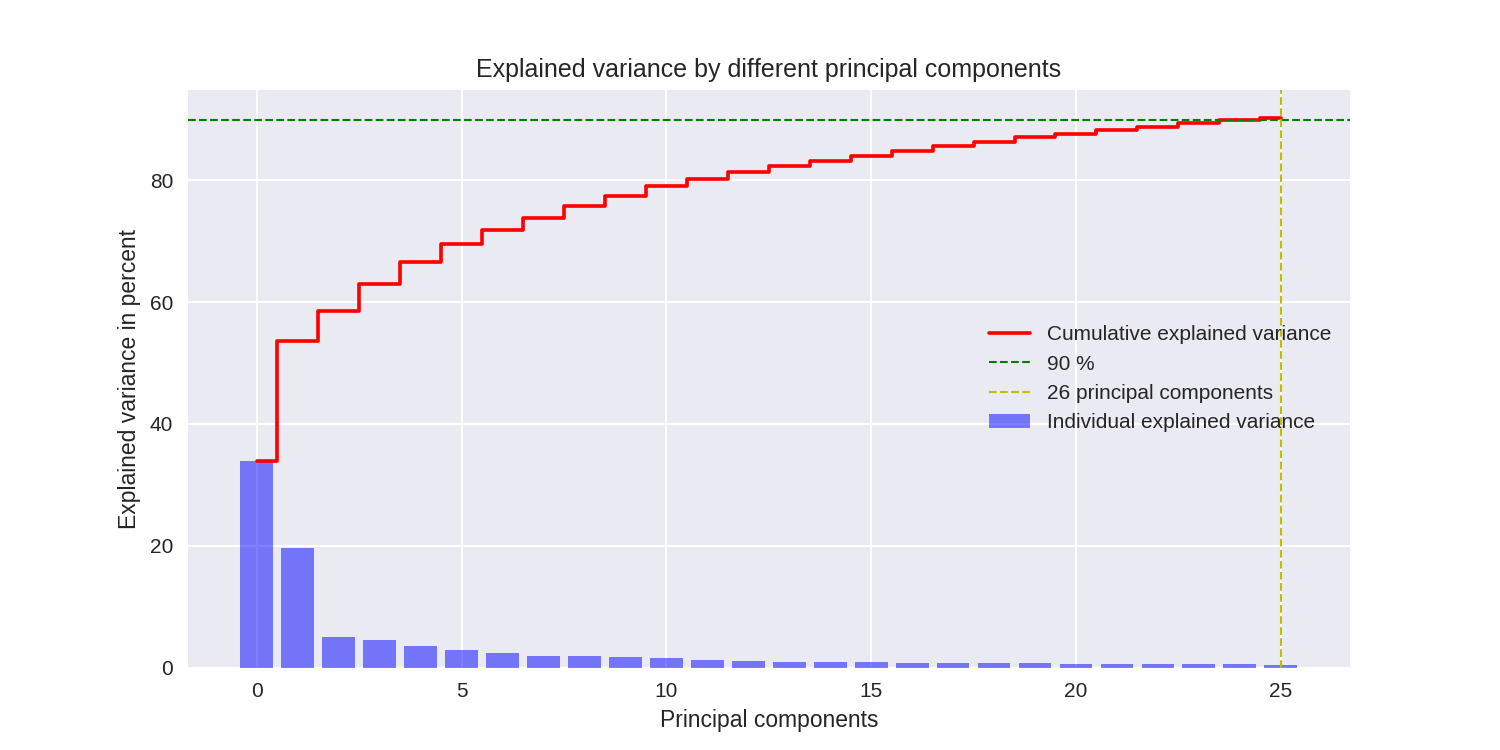

Explained variance with 26 principal components: 90.34747623566692 %


In [89]:
cum_var_explained = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10,5))
plt.bar(range(Ncomponents), pca.explained_variance_ratio_*100, alpha=0.5, align='center', label='Individual explained variance', color='b')
plt.step(range(Ncomponents), cum_var_explained*100 , where='mid', label='Cumulative explained variance', color='r')
plt.axhline(y=90, linewidth=1, color='g', linestyle='dashed', label='90 %')
plt.axvline(x=25, linewidth=1, color='y', linestyle='dashed', label='26 principal components')
plt.title('Explained variance by different principal components')
plt.ylabel('Explained variance in percent')
plt.xlabel('Principal components')
plt.legend(loc='center right')
plt.show()

print('Explained variance with 26 principal components: {} %'.format(sum(pca.explained_variance_ratio_[:26])*100))

### Clustering
You want to reduce the amount of field sensors to 20. You should now have from the previous question, an array with all your loading vectors (pca.components\_), one vector per principal component, with 137 elements (one per each sensor). Use clustering to group sensors that behave the same. 

**Q#5** How would you choose which sensors in each cluster you should keep?

For each cluster one sensor will be chosen to represent the given cluster. In each cluster, the sensor which is closest to the centroid is selected.

<IPython.core.display.Javascript object>


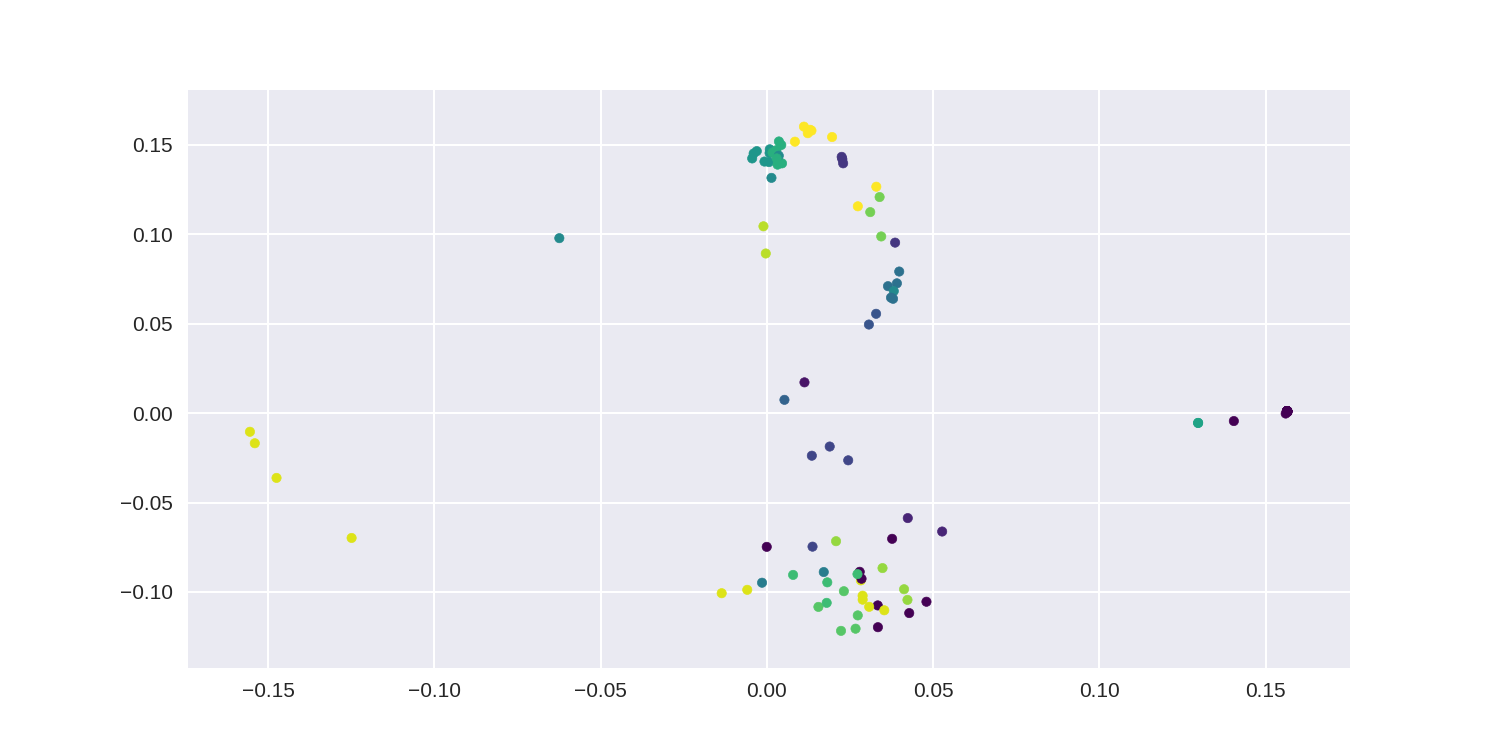

(26, 120)

In [91]:
from sklearn.cluster import KMeans
X_pca = pca.components_[[np.arange(0,26)]]

# Apply your clustering here
km = KMeans(n_clusters=20, init='k-means++',n_init=30, verbose=0);
km.fit(X_pca.T);
cluster_pred = km.predict(X_pca.T);
plt.figure(figsize=(10,5))
plt.scatter(X_pca[0], X_pca[1], c=cluster_pred, s=20, cmap='viridis')
plt.show()

X_pca.shape


In [106]:
from sklearn.metrics import pairwise_distances_argmin_min
closest, _ = pairwise_distances_argmin_min(km.cluster_centers_, X_pca.T)
df['reduced'] = df['no_nan'].iloc[:,closest]

print("Chosen sensors: ", df['reduced'].columns.tolist())

Chosen sensors:  ['load_node_153', 'prod_gen_12', 'renew_node_24', 'prod_gen_31', 'export_node_108', 'prod_gen_14', 'prod_gen_34', 'prod_gen_1', 'prod_gen_49', 'prod_gen_22', 'prod_gen_29', 'load_node_16', 'prod_gen_2', 'renew_node_143', 'renew_node_153', 'prod_gen_7', 'prod_gen_44', 'prod_gen_25', 'export_node_170', 'prod_gen_35']


### Save your chosen sensors

Now that you have chosen 20 sensors which are representative of your data, create a DataFrame that contains these sensors. You can save them to csv file using the code in the following cell.

In [108]:
# Assuming of course that your reduced data set is called data_reduced
df['reduced'].to_csv('reduced_field_data.csv')
df['reduced'].head()

,load_node_153,prod_gen_12,renew_node_24,prod_gen_31,export_node_108,prod_gen_14,prod_gen_34,prod_gen_1,prod_gen_49,prod_gen_22,prod_gen_29,load_node_16,prod_gen_2,renew_node_143,renew_node_153,prod_gen_7,prod_gen_44,prod_gen_25,export_node_170,prod_gen_35
time,,,,,,,,,,,,,,,,,,,,
2012-01-01 00:00:00,55.0930,0.0,153.470195,146.0,30.327760,0.0,40.0,0.0,0.0,191.6,132.0,110.1250,0.0,210.696216,49.787919,216.0,0.0,957.0,-1483.942990,0.0
2012-01-01 01:00:00,51.3680,0.0,146.519552,146.0,28.628956,0.0,40.0,0.0,0.0,191.6,132.0,105.8863,0.0,176.123772,40.675541,216.0,0.0,957.0,-1426.811167,0.0
2012-01-01 02:00:00,48.0104,0.0,138.456806,146.0,29.129438,0.0,40.0,0.0,0.0,191.6,132.0,100.9547,0.0,190.909471,35.260940,216.0,0.0,957.0,-1374.632122,0.0
2012-01-01 03:00:00,45.6761,0.0,102.313463,146.0,32.912220,0.0,40.0,0.0,0.0,191.6,132.0,93.1905,0.0,195.693080,35.525067,216.0,0.0,957.0,-1311.463964,0.0
2012-01-01 04:00:00,44.6987,0.0,77.569175,146.0,42.026312,0.0,40.0,0.0,0.0,191.6,132.0,87.1585,0.0,222.437801,34.204433,216.0,0.0,957.0,-1285.376107,0.0
